In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import scipy as sp --- from scipy import xxx
import pandas as pd
import seaborn as sns

In [2]:
song_data = pd.read_csv("./data/song_data.csv")

In [3]:
song_data.shape

(18835, 15)

In [4]:
song_data.columns

Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [5]:
song_data.dtypes

song_name            object
song_popularity       int64
song_duration_ms      int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
audio_mode            int64
speechiness         float64
tempo               float64
time_signature        int64
audio_valence       float64
dtype: object

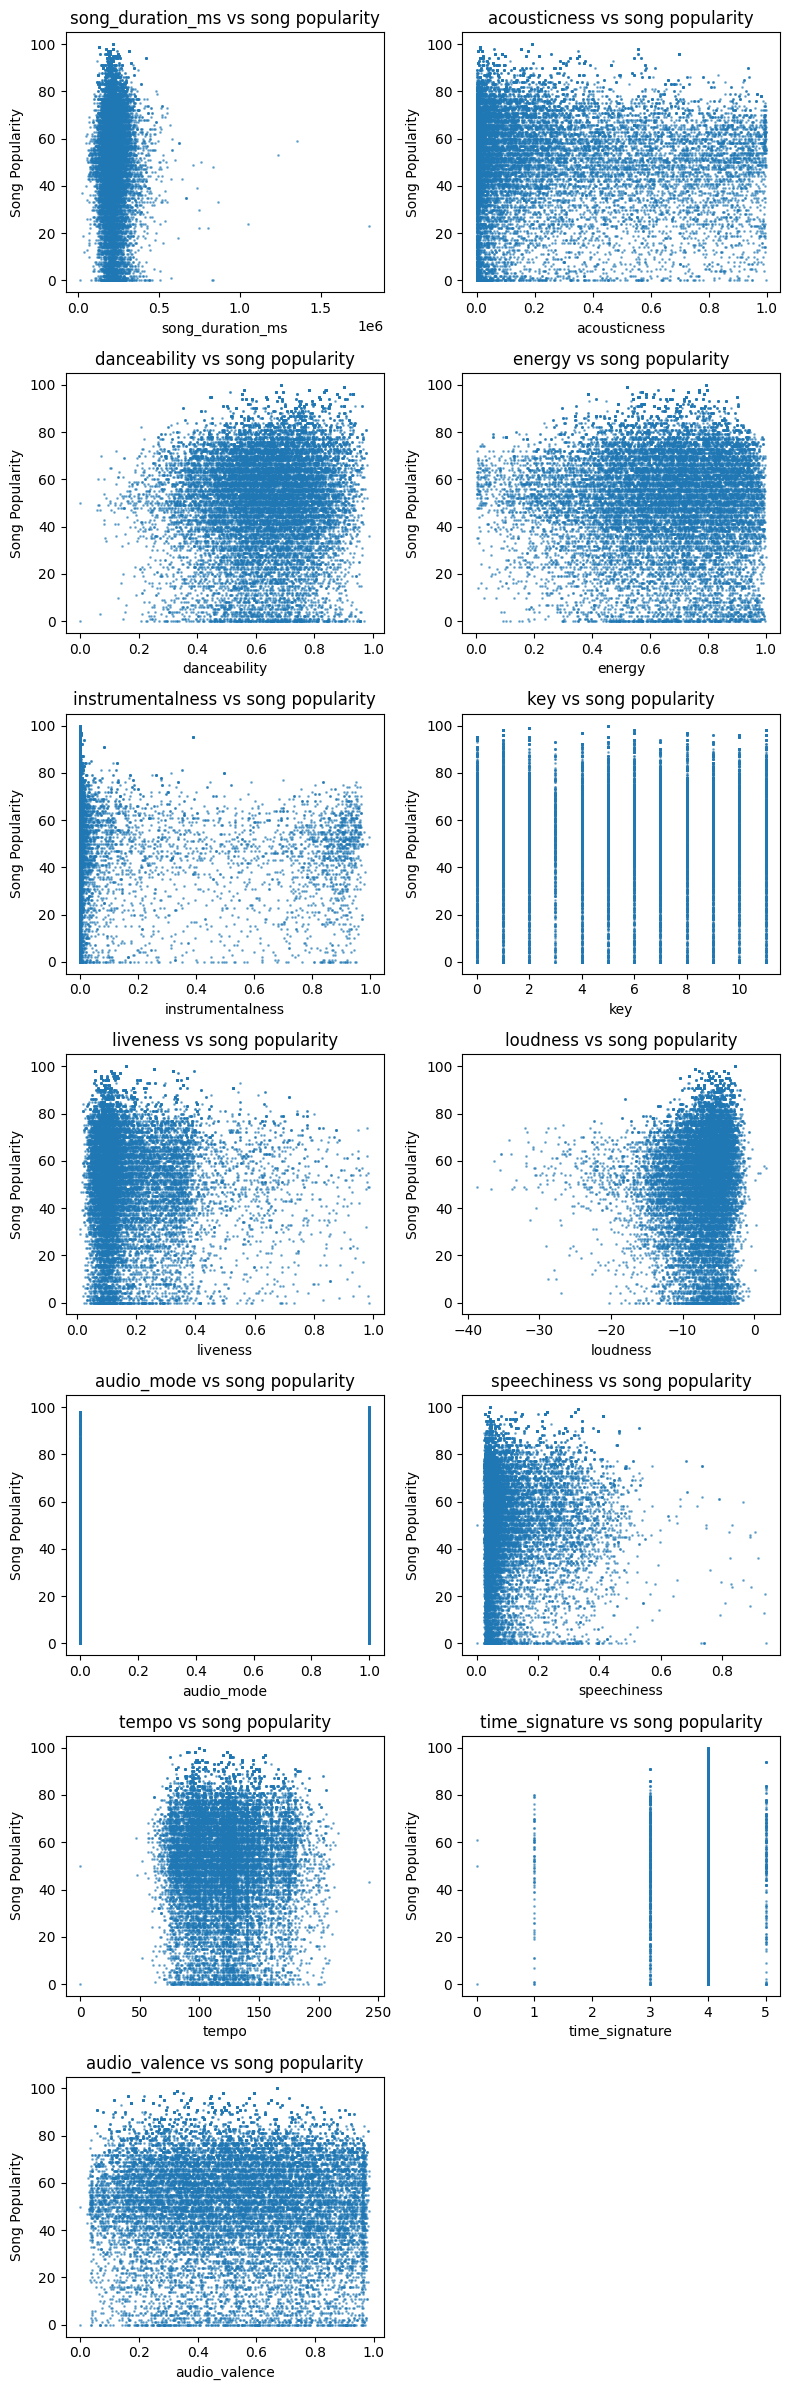

In [11]:
import matplotlib.pyplot as plt

# Remove the 'song_name' column
song_data = song_data.drop(columns=['song_name'])

# Features to plot against 'song_popularity'
features = song_data.columns.drop('song_popularity')

# Create scatter plots for each feature against 'song_popularity'
plt.figure(figsize=(8, 24))
for i, feature in enumerate(features, 1):
    plt.subplot(7, 2, i)  # Create a grid of subplots (5 rows, 3 columns)
    plt.scatter(song_data[feature], song_data['song_popularity'], alpha=0.5, s=1)
    plt.title(f'{feature} vs song popularity')
    plt.xlabel(feature)
    plt.ylabel('Song Popularity')
    plt.tight_layout()

plt.show()

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [13]:
# Feature selection based on correlation with `song_popularity`
# correlation_threshold = 0.2
# selected_features = song_data.corr()['song_popularity'].abs().sort_values(ascending=False)
# selected_features = selected_features[selected_features > correlation_threshold].index.drop('song_popularity')
# print(f"Selected features: {list(selected_features)}")

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

In [15]:


# 1. Univariate Feature Selection using SelectKBest
# Use statistical tests (e.g., ANOVA F-value) to score each feature
k = 8  # Number of top features to select
select_k_best = SelectKBest(score_func=f_regression, k=k)
X_selected_kbest = select_k_best.fit_transform(song_data.drop(columns=['song_popularity']), song_data['song_popularity'])

# Get selected feature names
selected_kbest_features = song_data.drop(columns=['song_popularity']).columns[select_k_best.get_support()]
print(f"Top {k} features from SelectKBest: {list(selected_kbest_features)}")

# 2. Feature Importance from Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(song_data.drop(columns=['song_popularity']), song_data['song_popularity'])

# Sort features by importance
importance_scores = pd.Series(rf.feature_importances_, index=song_data.drop(columns=['song_popularity']).columns)
selected_rf_features = importance_scores.nlargest(k).index
print(f"Top {k} features from Random Forest: {list(selected_rf_features)}")

# 3. Recursive Feature Elimination (RFE) with Linear Regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=k)
rfe.fit(song_data.drop(columns=['song_popularity']), song_data['song_popularity'])

# Get selected features
selected_rfe_features = song_data.drop(columns=['song_popularity']).columns[rfe.support_]
print(f"Top {k} features from RFE: {list(selected_rfe_features)}")

# Final Selected Features
final_selected_features = list(set(selected_kbest_features) & set(selected_rf_features) & set(selected_rfe_features))
print(f"Features selected by all methods: {final_selected_features}")


Top 8 features from SelectKBest: ['acousticness', 'danceability', 'instrumentalness', 'liveness', 'loudness', 'tempo', 'time_signature', 'audio_valence']
Top 8 features from Random Forest: ['loudness', 'danceability', 'audio_valence', 'acousticness', 'song_duration_ms', 'energy', 'instrumentalness', 'tempo']
Top 8 features from RFE: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'time_signature', 'audio_valence']
Features selected by all methods: ['audio_valence', 'instrumentalness', 'acousticness', 'danceability']


In [16]:
# Splitting the data
X = song_data[final_selected_features]
y = song_data['song_popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

Linear Regression: MSE=464.36, R2=0.04


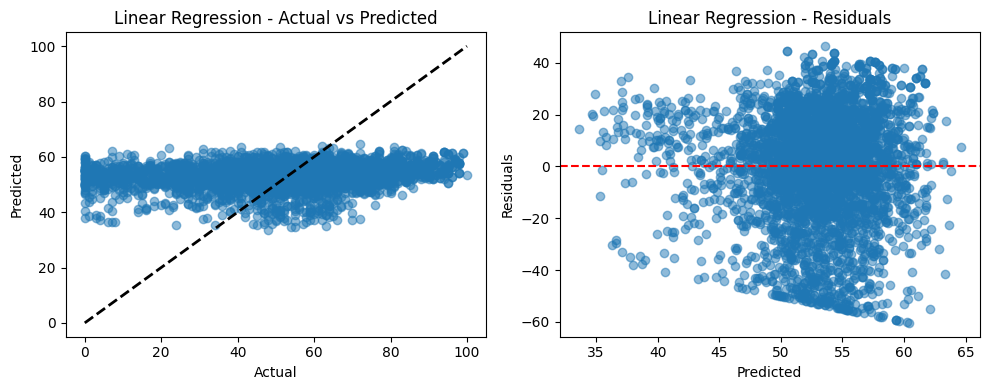

Ridge Regression: MSE=464.36, R2=0.04


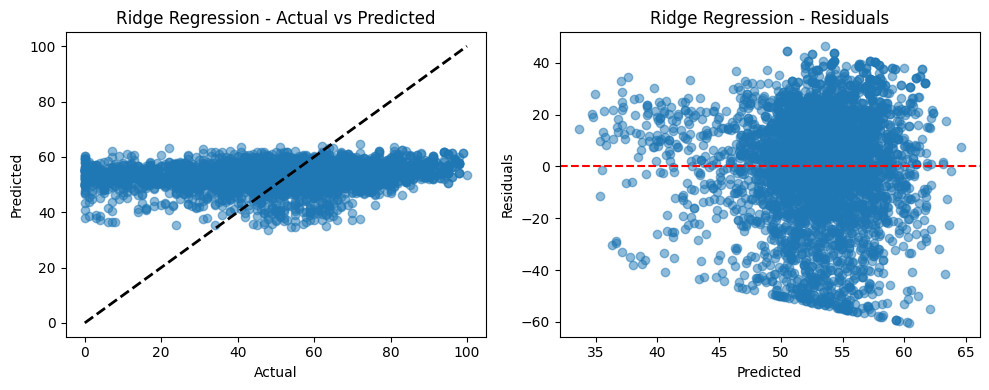

Lasso Regression: MSE=464.36, R2=0.04


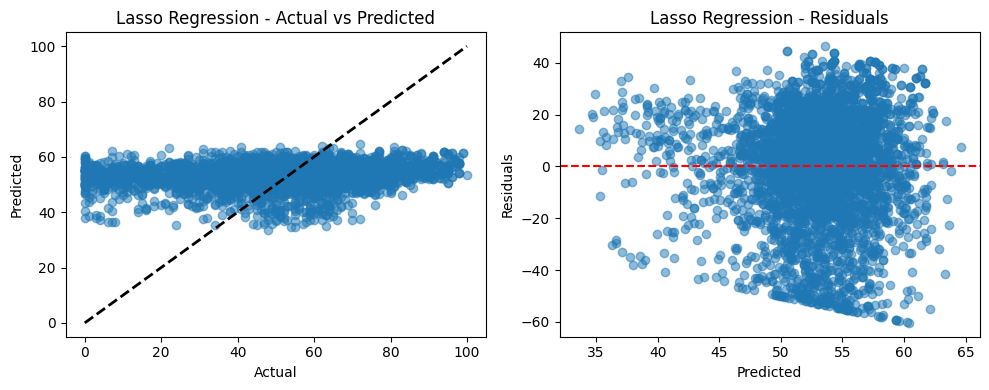

Random Forest: MSE=325.99, R2=0.32


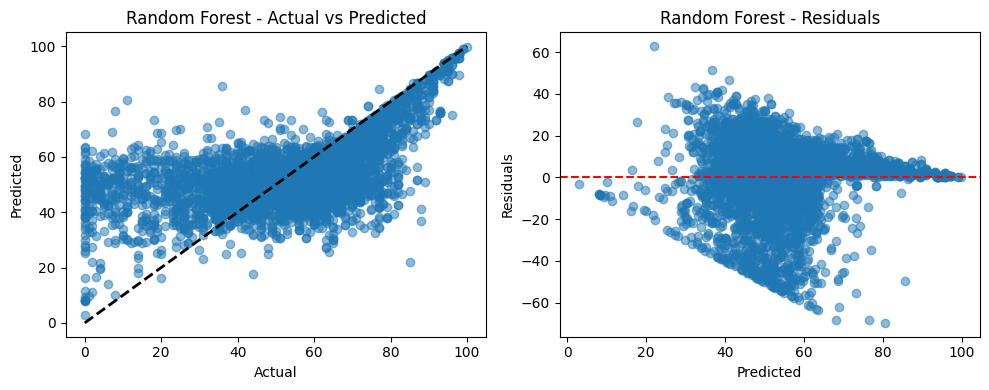

In [19]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    # Hyperparameter tuning for Ridge, Lasso, and Random Forest
    if name in ["Ridge Regression", "Lasso Regression"]:
        params = {'alpha': np.logspace(-4, 4, 10)}
        grid = GridSearchCV(model, param_grid=params, scoring='r2', cv=5)
        grid.fit(X_train_scaled, y_train)
        model = grid.best_estimator_
    elif name == "Random Forest":
        params = {'n_estimators': [100, 200, 500], 'max_depth': [5, 10, 20]}
        grid = GridSearchCV(model, param_grid=params, scoring='r2', cv=5)
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
    else:
        model.fit(X_train_scaled, y_train)

    # Predictions
    if name in ["Linear Regression", "Ridge Regression", "Lasso Regression"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}
    print(f"{name}: MSE={mse:.2f}, R2={r2:.2f}")

    # Visualizations: Actual vs Predicted, Residual plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.title(f"{name} - Actual vs Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{name} - Residuals")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

Feature Importance (Top Features):
loudness            0.105921
danceability        0.098546
audio_valence       0.098142
acousticness        0.095277
song_duration_ms    0.092983
energy              0.092314
instrumentalness    0.090814
tempo               0.090015
speechiness         0.089205
liveness            0.089179
key                 0.043239
audio_mode          0.009325
time_signature      0.005039
dtype: float64


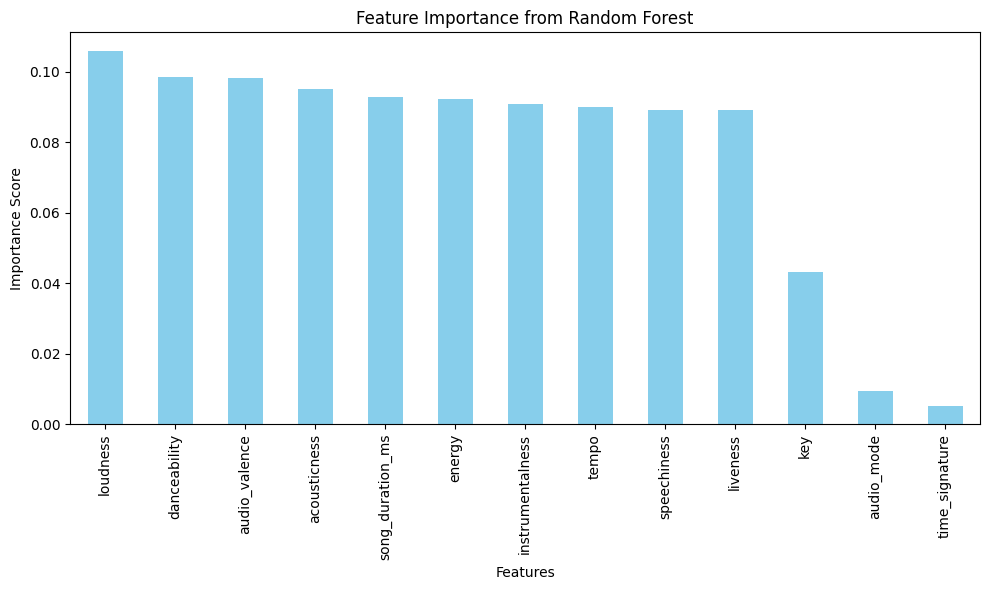

In [20]:
# # Feature Importance for Random Forest
# rf_model = models["Random Forest"]
# rf_model.fit(X_train, y_train)
# importances = pd.Series(rf_model.feature_importances_, index=selected_features).sort_values(ascending=False)

# Define features (X) and target (y)
X = song_data.drop(columns=['song_popularity'])
y = song_data['song_popularity']

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X, y)

# Extract feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print the top features
print("Feature Importance (Top Features):")
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.show()

In [ ]:
# Compare model performance
performance_df = pd.DataFrame(results).T
performance_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()